### Load packages and read tables.

In [2]:
%run /Users/J.Kim54@lse.ac.uk/pubg_analysis

In [3]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import StructType, StructField, LongType

# Read telemetry data.
td = spark.read.parquet("/tmp/td_day_3_6.parquet")
td.registerTempTable("td")

# Read the information of cheaters.
cheaters = spark.read.parquet("/tmp/cheater_info.parquet")
cheaters.registerTempTable("cheaters")

# Add the information of cheaters to the node table.
players = spark.sql("""SELECT t.id, t.pname, CASE WHEN c.start_date IS NULL THEN 0 ELSE 1 END AS cheating_flag, 
                       CASE WHEN c.start_date IS NULL THEN 'NA' ELSE c.start_date END AS start_date, 
                       CASE WHEN c.ban_date IS NULL THEN 'NA' ELSE c.ban_date END AS ban_date 
                       FROM td_nodes t LEFT JOIN cheaters c ON t.id = c.id""")
players.registerTempTable("nodes")

### Count the number of motifs on the empirical network.

In [5]:
# First, add the start date information of cheating into the telemetry data.
src_dt = spark.sql("""SELECT mid, src, start_date AS src_sd, src_bd, src_flag, dst, dst_bd, dst_flag, time, m_date 
                      FROM td t JOIN nodes n ON t.src = n.id""")
src_dt.registerTempTable("src_dt")
full_info = spark.sql("""SELECT mid, src, src_sd, src_bd, src_flag, dst, start_date AS dst_sd, dst_bd, dst_flag, time, m_date 
                         FROM src_dt s JOIN nodes n ON s.dst = n.id""")
full_info.registerTempTable("records")

# Count the motifs on the empirical network without taking into account the damage done to victims.
paths, num_of_motifs = count_basic_motifs(full_info, players)
print(num_of_motifs)

# Count the number of motifs on the empirical network considering the severity of harm caused by cheating.
sev_paths, num_of_motifs_with_severe_harm = count_motifs_with_severe_harm(full_info, 30)
print(num_of_motifs_with_severe_harm)

184
84

### Test for different levels of harm.

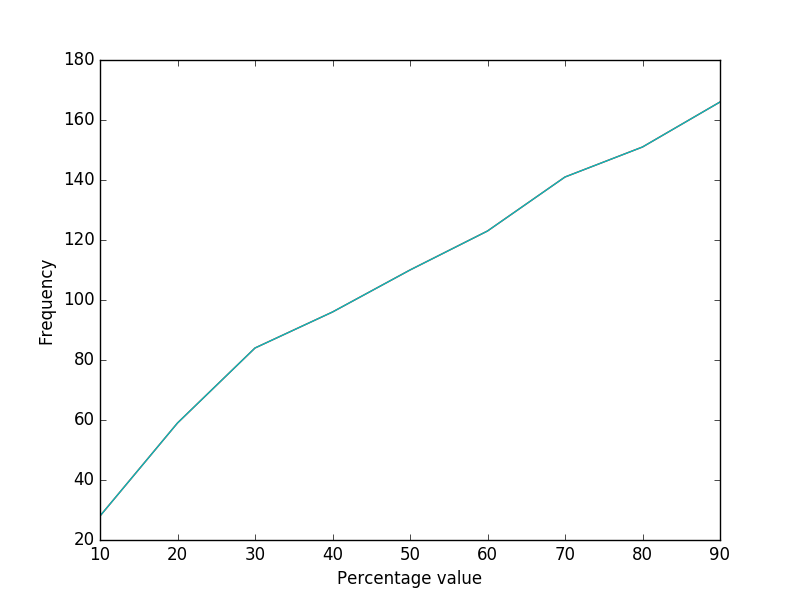

In [7]:
num_of_motifs_lst = []
diff_lvls = list(range(10, 100, 10))

for i in diff_lvls:
    sev_paths, num_of_motifs = count_motifs_with_severe_harm(full_info, i)
    num_of_motifs_lst.append(num_of_motifs)

# print(num_of_motifs_lst)

# Plot the results for different levels of harm.
fig = plt.plot(diff_lvls, num_of_motifs_lst)
plt.xlabel("Percentage value")
plt.ylabel("Frequency")
plt.title("")
image = plt.show()
display(image)

### Create a function that automatically returns 3-actor or 4-actor motifs.

In [9]:
# The function below will be moved into pubg_analysis.py upon completion.
def test_for_multiple_killings(paths, mod):
    """This function returns motifs based on the given conditions.
       Args:
           paths: Dataframe that contains motifs
           mod: Number of actors (players) who got involved in the motif
           comb: Binary value which decides whether to count combinations of motifs or not. 
                 The function counts combinations if the value is one.
                 The value is set to zero by default.
                 Will later be updated.
       Returns:
           motifs: Dataframe that contains motifs that satisfy the given conditions.
    """
    if mod == 3:
        # Count 3-actor motifs (killed by 2 cheaters).
        pairs = spark.sql("SELECT src, dst FROM paths WHERE period <= 7 GROUP BY src, dst")
        pairs.registerTempTable("pairs")
        unique_pair_cnt = spark.sql("SELECT dst, COUNT(*) AS contacts FROM pairs GROUP BY dst")
        unique_pair_cnt.registerTempTable("unique_pair_cnt")
        three_actor_motifs = spark.sql("SELECT * FROM unique_pair_cnt WHERE contacts = 2")
        motif_cnt = three_actor_motifs.count()
    elif mod == 4:
        # Count 4-actor motifs (killed by 3 cheaters).
        four_actor_motifs = spark.sql("SELECT * FROM unique_pair_cnt WHERE contacts = 3")
        motif_cnt = four_actor_motifs.count()
    else:
        print("Invalid input")
        return
    
    return motif_cnt

  
paths.registerTempTable("paths")
three_actor_motifs_cnt = test_for_multiple_killings(paths, 3)
print(three_actor_motifs_cnt)
four_actor_motifs_cnt = test_for_multiple_killings(paths, 4)
print(four_actor_motifs_cnt)

28
4

### Plot the indegree distribution (overall).

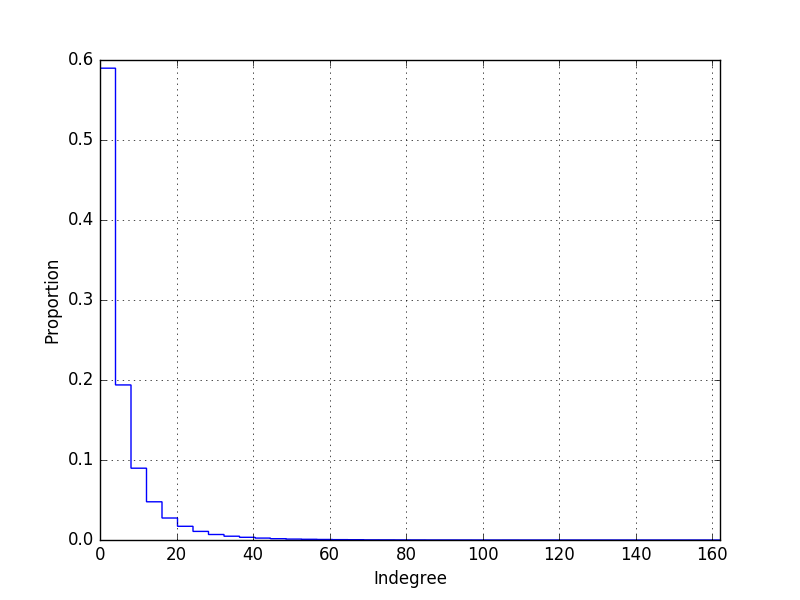

In [11]:
# Count deaths (indegree) of each player.
death_logs = spark.sql("SELECT mid, dst, time, m_date FROM records")
death_logs.registerTempTable("death_logs")
indegs = spark.sql("SELECT dst AS id, COUNT(*) AS indeg FROM death_logs GROUP BY dst")
indegs_df = indegs.toPandas()

# Create a table that contains unique player IDs.
unique_ids = spark.sql("SELECT DISTINCT src AS id FROM records UNION SELECT DISTINCT dst AS id FROM records")
ids_df = unique_ids.toPandas()

# Merge the two dataframes into one.
indegs_tab = pd.merge(ids_df, indegs_df, how='outer', on=['id'])
indegs_tab = indegs_tab.fillna(0)

# plot the indegree distribution of players.
bins = np.arange(0, indegs_tab['indeg'].max() + 1.5) - 0.5
fig = indegs_tab.hist(column = 'indeg', histtype='step', bins = 40,
                      weights=np.zeros_like(indegs_tab['indeg'])+1./len(indegs_tab['indeg']))
plt.xlim(xmin=0)
plt.xlim(xmax=indegs_tab['indeg'].max())
plt.xlabel("Indegree")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

### Plot the indegree distribution of cheaters.

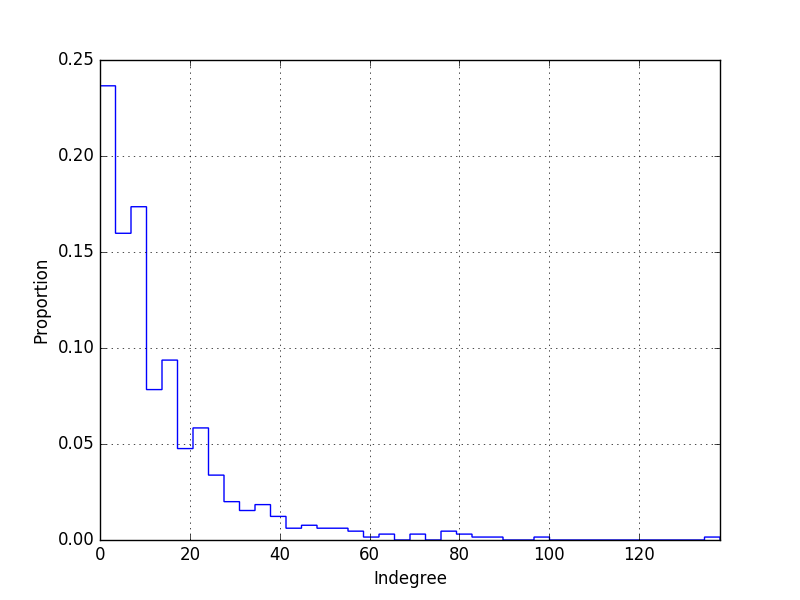

In [13]:
# Merge the two dataframes into one.
cheater_ids = spark.sql("SELECT id FROM cheaters WHERE ban_date <= '2019-03-03'")
cheaters_df = cheater_ids.toPandas()
# print(cheaters_df)

cheater_indegs = pd.merge(indegs_tab, cheaters_df)
# print(cheater_indegs)

# plot the indegree distribution of players.
bins = np.arange(0, cheater_indegs['indeg'].max() + 1.5) - 0.5
fig = cheater_indegs.hist(column = 'indeg', histtype='step', bins = 40,
                          weights=np.zeros_like(cheater_indegs['indeg'])+1./len(cheater_indegs['indeg']))
plt.xlim(xmin=0)
plt.xlim(xmax=cheater_indegs['indeg'].max())
plt.xlabel("Indegree")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

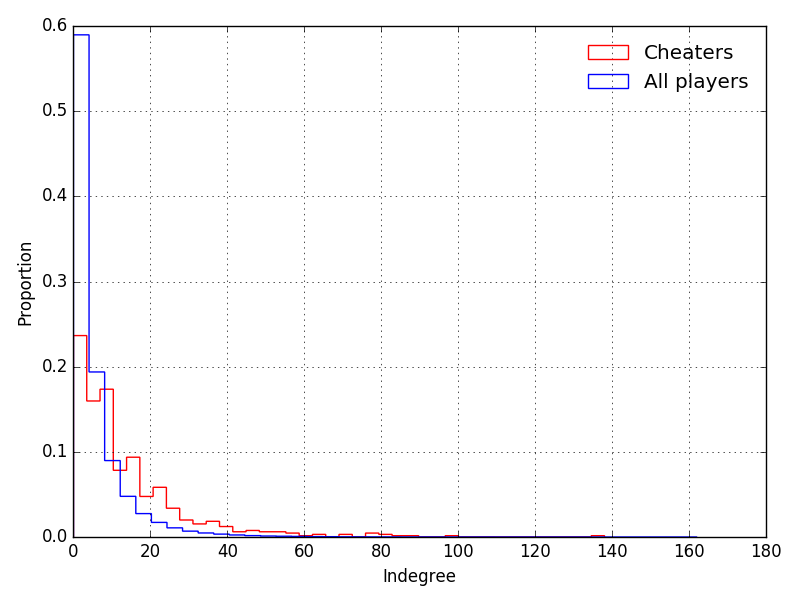

In [14]:
# Combine the two plots.
# Plot the histograms of cheaters and non-cheaters together.
ax = cheater_indegs.hist(column='indeg', histtype='step', weights=np.zeros_like(cheater_indegs['indeg'])+1./len(cheater_indegs['indeg']), 
                         edgecolor='red', bins=40, label='Cheaters')
fig = indegs_tab.hist(column='indeg', histtype='step', weights=np.zeros_like(indegs_tab['indeg'])+1./len(indegs_tab['indeg']), 
                      edgecolor='blue', bins=40, label='All players', ax=ax)
plt.title('')
plt.xlabel('Indegree')
plt.ylabel('Proportion')
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
image = plt.show() 
display(image)

### Plot the distribution of contacts with cheaters before adopting cheating.

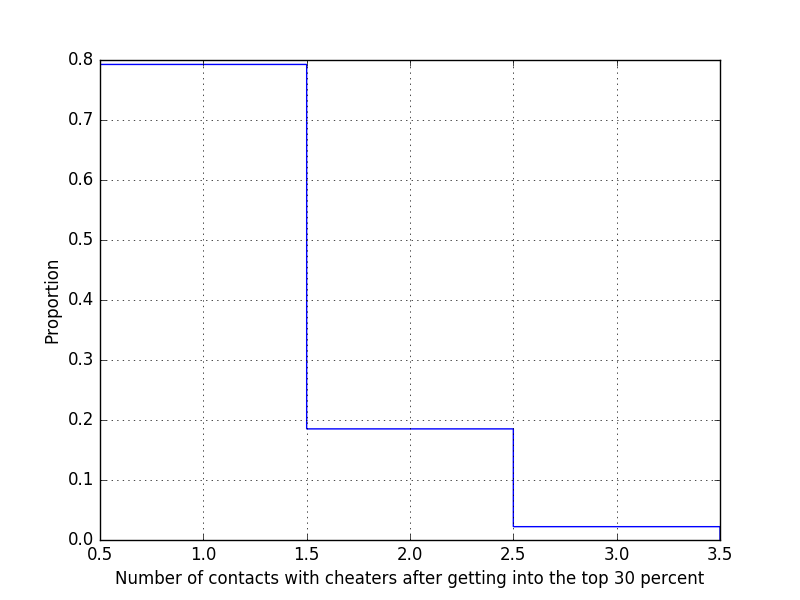

In [16]:
# Consider the cases where victims were severely harmed.
# Count the number of contacts with cheaters before the transition happened.
# We allow duplicate pairs of killer and victim as there are some victims who have been killed by the same killer more than once. 
contact_cnt = spark.sql("SELECT dst, COUNT(*) AS contacts FROM severity_paths WHERE damage == 1 AND period <= 7 GROUP BY dst")
contact_cnt_df = contact_cnt.toPandas()

bins = np.arange(0, contact_cnt_df['contacts'].max() + 1.5) - 0.5
fig = contact_cnt_df.hist(column = 'contacts', histtype='step', bins = bins, 
                          weights=np.zeros_like(contact_cnt_df['contacts'])+1./len(contact_cnt_df['contacts']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of contacts with cheaters after getting into the top 30 percent")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

### Plot the number of contacts with unique cheaters before adopting cheating.

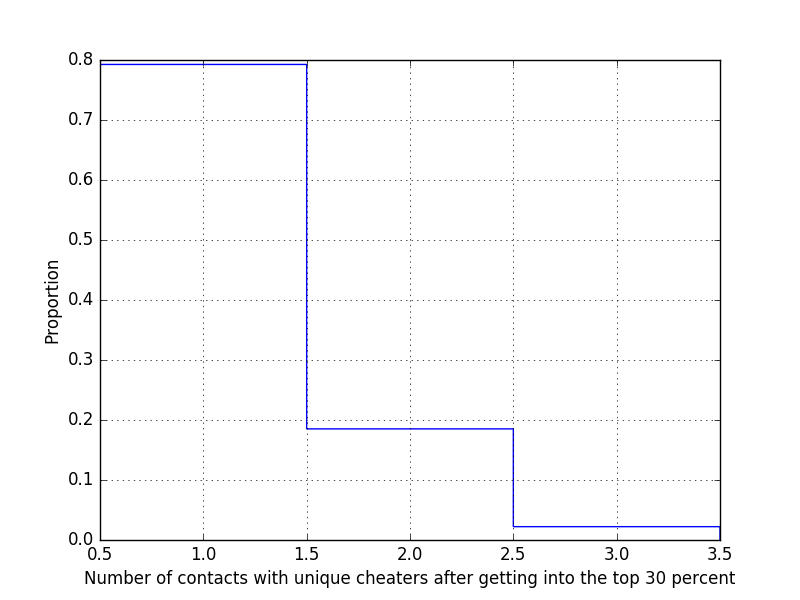

In [18]:
# In this case, we consider only unique pairs of killer and victim.
pairs = spark.sql("SELECT src, dst FROM severity_paths WHERE damage == 1 AND period <= 7 GROUP BY src, dst")
pairs.registerTempTable("pairs")
unique_pair_cnt = spark.sql("SELECT dst, COUNT(*) AS contacts FROM pairs GROUP BY dst")
# display(unique_pair_cnt)

unique_pair_cnt_df = unique_pair_cnt.toPandas()
bins = np.arange(0, unique_pair_cnt_df['contacts'].max() + 1.5) - 0.5
fig = unique_pair_cnt_df.hist(column = 'contacts', histtype='step', bins = bins, 
                              weights=np.zeros_like(unique_pair_cnt_df['contacts'])+1./len(unique_pair_cnt_df['contacts']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of contacts with unique cheaters after getting into the top 30 percent")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

### Plot the distribution of transition period.

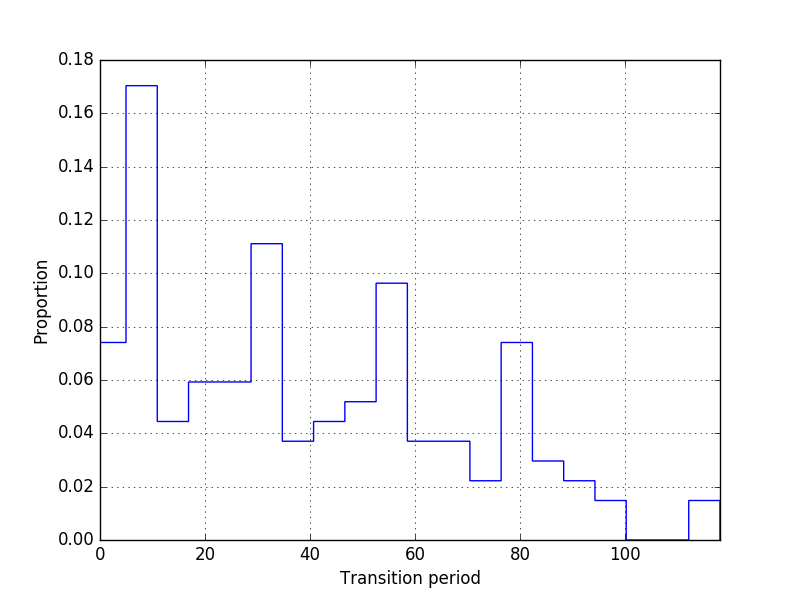

In [20]:
raw_pairs = spark.sql("SELECT * FROM severity_paths WHERE damage == 1 AND period <= 7 ORDER BY time")
raw_pairs.registerTempTable("raw_pairs")

# Calculate the time difference between the first victimisation experience and start date for each cheater.
first_vic_exp = spark.sql("""SELECT * 
                             FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY dst ORDER BY time) AS rownumber FROM raw_pairs) AS first_vic_exp 
                             WHERE rownumber IN (1)""")
first_vic_exp.registerTempTable("first_vic_exp")
# display(first_vic_exp)
add_start_date = spark.sql("SELECT dst, time, start_date AS dst_sd FROM first_vic_exp f JOIN nodes n ON f.dst = n.id")
# display(add_start_date)
add_start_date_df = add_start_date.toPandas()
add_start_date_df['time'] = pd.to_datetime(add_start_date_df['time'])
add_start_date_df['dst_sd'] = pd.to_datetime(add_start_date_df['dst_sd'])
add_start_date_df['period'] = (add_start_date_df['dst_sd'] - add_start_date_df['time']).astype('timedelta64[h]')

bins = np.arange(0, add_start_date_df['period'].max() + 1.5) - 0.5
fig = add_start_date_df.hist(column = 'period', histtype='step', bins = 20,
                             weights=np.zeros_like(add_start_date_df['period'])+1./len(add_start_date_df['period']))
plt.xlim(xmin=0)
plt.xlim(xmax=add_start_date_df['period'].max())
plt.xlabel("Transition period")
plt.ylabel("Proportion")
plt.title("")
image = plt.show() 
display(image)

### Permute the node labels of the original network to create a randomised network.
* Team membership information will be added.

In [22]:
td.registerTempTable("raw_td")
rand_logs = permute_node_labels(td, players)
rand_logs.registerTempTable("rand_logs")

### Count the number of motifs on the randomised network.

In [24]:
# First, add the start date information of cheating into the telemetry data.
src_dt = spark.sql("""SELECT mid, src, start_date AS src_sd, cheating_flag AS src_flag, dst, time, m_date 
                      FROM rand_logs r JOIN nodes n ON r.src = n.id""")
src_dt.registerTempTable("src_dt")
full_info = spark.sql("""SELECT mid, src, src_sd, src_flag, dst, start_date AS dst_sd, cheating_flag AS dst_flag, time, m_date 
                         FROM src_dt s JOIN nodes n ON s.dst = n.id""")
full_info.registerTempTable("records")

# Count the motifs on the randomised network without taking into account the damage done to victims.
paths, num_of_motifs = count_basic_motifs(full_info, players)
print(num_of_motifs)

# Count the number of motifs on the randomised network considering the severity of harm caused by cheating.
sev_paths, num_of_motifs_with_severe_harm = count_motifs_with_severe_harm(full_info, 30)
print(num_of_motifs_with_severe_harm)

186
72

### Check how many times team-killing occurs.

In [26]:
# I am temporarily using team membership information between March 1 and March 3 due to the size limit.
team_info = spark.read.parquet("/tmp/team_info.parquet")
team_info.registerTempTable("team_info")
participant_lst = spark.sql("""SELECT * FROM (SELECT mid, src AS id, tid FROM team_info 
                               UNION SELECT mid, dst AS id, tid FROM team_info) ORDER BY mid""")
# display(participant_lst)
# This part will be moved to the first notebook.

In [27]:
# Count the number of team-killings happened in the empirical network.
td.registerTempTable("kill_logs")
participant_lst.registerTempTable("participants")
num_of_team_kills_emp = check_team_killing(td, participant_lst)
print(num_of_team_kills_emp)

# Count the number of team-killings happened in the randomised network.
rand_logs.registerTempTable("kill_logs")
num_of_team_kills_rand = check_team_killing(rand_logs, participant_lst)
print(num_of_team_kills_rand)

25347
88665

### Plot the distribution of test statistics.

In [29]:
# Plot the distribution of test statistics considering the severity of harm done by cheating.
# num_of_motifs_emp = 107
# test_stats = [86, 84, 75, 87]

# Plot the distribution of test statistics without considering the severity of harm done by cheating.
num_of_motifs_emp = 224
test_stats = [202, 223, 205, 189]

# plot_dist_of_test_stats(num_of_motifs_emp, test_stats)